## Business problem

perusahaan memiliki problem tentang kurangnya pemahaman yang mendalam tentang perilaku pembelian pelanggan, kebutuhan dan preferensi mereka, serta kesulitan dalam mengoptimalkan strategi penjualan dan pemasaran.

Perusahaan ingin mengetahui seberapa baik kinerja penjualan produk mereka dan ingin melakukan analisis segmentasi untuk membantu dalam memahami pola perilaku pembelian pelanggan, mengidentifikasi segmen pelanggan yang paling menguntungkan, dan memahami preferensi dan kebutuhan pelanggan yang berbeda-beda.

**Objective Analysis :**

* Understand the Dataset & cleanup.
* Build a clustering model to segment the customer-based similarity.

**Goals :**

mendapatkan wawasan yang lebih mendalam tentang perilaku pembelian pelanggan dan mengambil keputusan berdasarkan pemahaman yang lebih baik tentang segmen pelanggan terutama untuk strategi promosi dan rekomendasi product berdasarkan pola kebiasaan pelanggan.

## Import Package

In [ ]:
!pip install pandasql

In [ ]:
!pip install SQLAlchemy==1.4.46

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import pandasql as ps
import matplotlib.pyplot as plt
import psycopg2
from sqlalchemy import create_engine
%matplotlib inline


## Data Understanding

### Load dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/tugas dibimbing/Extra Class 7/Online Retail.csv')
retail=data.copy()
retail.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


### Data Information

In [ ]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


* dataset terdiri dari 541909 baris dan 8 kolom
* Terlihat ada missing values di beberapa kolom. Untuk  tipe data tidak ada yang bermasalah kecuali di InvoiceDate yang seharusnya bertipe datetime

### Statistical Summary

In [ ]:
# membagi nama kolom berdasarkan tipe datanya
numericals = retail.select_dtypes(include=['int64','float64']).columns.tolist()
categoricals = retail.select_dtypes(exclude=['int64','float64']).columns.tolist()

print(f"numericals columns are {numericals}")
print(f"categoricals columns are {categoricals}")

numericals columns are ['Quantity', 'UnitPrice', 'CustomerID']
categoricals columns are ['InvoiceNo', 'StockCode', 'Description', 'InvoiceDate', 'Country']


In [ ]:
categoricals = ['InvoiceNo', 'StockCode', 'Description', 'InvoiceDate', 'Country']

numericals = ['Quantity', 'UnitPrice', 'CustomerID']

#### numerical statistical summary

In [ ]:
# numerical statistical summary
retail[numericals].describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


Observations:

* mean > median di kolom `Quantity` dan `UnitPrice` mengindikasikan distribusi skew.
* kolom Quantity dan UnitPrice memiliki nilai minus yang tidak wajar
* kolom quantity memiliki rentang yang besar antara minimum dan maximum. Dapat mengindikasikan ketidakseimbangan antara permintaan pelanggan dan kemampuan perusahaan untuk memenuhi permintaan tersebut. ataupun bisa disebabkan oleh hal lain.Kita akan lakukan validasi.
* Rentang yang sangat besar antara nilai minimum dan maksimum dalam kolom unitprice menunjukkan adanya variasi harga yang signifikan di produk atau layanan perusahaan. Dapat menunjukkan adanya masalah dalam proses penetapan harga. Misalnya, harga yang sangat rendah mungkin mengindikasikan adanya diskon yang berlebihan atau penurunan harga yang tidak diinginkan. Bisa juga disebabkan oleh hal-hal lain. Kita akan lakukan validasi

<!-- * A mean > median in passenger_count and trip_duration indicates a positively skewed distribution.
* `pickup_longitude`, `pickup_latitude`,`dropoff_longitude`,`dropoff_latitude` exhibit a normal distribution as the gap between the mean and median is less than 10%. -->





##### Data validation-Numerical

In [ ]:
quantity_min=retail[retail['Quantity']<0]

In [ ]:
quantity_min

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


Data Quantity yang minus ternyata berasal dari InvoiceNo yang diawali dengan huruf C yang berarti disebabkan oleh adanya pesanan yang di cancel oleh customer.



In [ ]:
filtered_data_min = quantity_min[~quantity_min['InvoiceNo'].str.contains('C', case=False)]

In [ ]:
filtered_data_min

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
2406,536589,21777,NaN,-10,2010-12-01 16:50:00,0.0,NaN,United Kingdom
4347,536764,84952C,NaN,-38,2010-12-02 14:42:00,0.0,NaN,United Kingdom
7188,536996,22712,NaN,-20,2010-12-03 15:30:00,0.0,NaN,United Kingdom
7189,536997,22028,NaN,-20,2010-12-03 15:30:00,0.0,NaN,United Kingdom
7190,536998,85067,NaN,-6,2010-12-03 15:30:00,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535333,581210,23395,check,-26,2011-12-07 18:36:00,0.0,NaN,United Kingdom
535335,581212,22578,lost,-1050,2011-12-07 18:38:00,0.0,NaN,United Kingdom
535336,581213,22576,check,-30,2011-12-07 18:38:00,0.0,NaN,United Kingdom
536908,581226,23090,missing,-338,2011-12-08 09:56:00,0.0,NaN,United Kingdom


Selain karena data ada huruf C ternyata quantity yang minus juga diisi oleh data yang tidak mengandung huruf C didepannya. Namun ternyata customer Id nya adalah Nan(missing). Maka kita akan menghapusnya saat di drop_missing value

In [ ]:
retail[retail['UnitPrice']<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


In [ ]:
retail[retail['StockCode']=='B']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


Setelah kita lihat,ternyata  UnitPrice yang minus berasal dari StockCode 'B' dan dengan deskripsi 'Adjust bad debt' yang terdiri hanya dari 3 baris dimana salah satu kolomnya tidak minus

Untuk menghapus kolom yang terdapat **minus di UnitPrice**, kita akan menghapus kolom StockCode yang berkode 'B' dimana hanya terdapat 3 baris. Selain itu kita harus menghapusnya karena nilai dari CustomerID dari StockCode yang mengandung 'B' adalah Nan

In [ ]:
retail=retail.drop(retail[retail['StockCode']=='B'].index).reset_index(drop=True)

In [ ]:
retail.shape

(541906, 8)

#### categorical statistical summary

In [ ]:
# describe method on categorical data
retail[categoricals].describe()

,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,541906,541906,540452,541906,541906
unique,25897,4069,4222,23258,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2011-10-31 14:41:00,United Kingdom
freq,1114,2313,2369,1114,495475


Observations:

<!-- * The top pickup date is 2016-04-05  (5 rows).
* The top dropoff date is 2016-02-19 (5 rows).
* The majority of store and forward flags are N, indicating that on average, trip records are not stored in the vehicle's memory before being sent to the vendor (1450592). -->

* InvoiceNo yang paling top adalah 573585 (1114 rows)
* StockCode yang paling populer adalah 85123A (2270 rows)
* Description / product yang paling populer adalah WHITE HANGING HEART T-LIGHT HOLDER	(2327)
* InvoiceDate yang paling banyak adalah 2011-10-31 (1114 rows)
* Country dari customer yang populer adalah United Kingdom (486283)

<!-- * The majority of customers are female (5545 rows).
* The most preferred shipping method by customers is `Ship` compared to other shipping methods (7462 rows).
* The warehouse block with the highest frequency is block F (3666 rows).
* The most common product importance category is "low" (5297 rows). -->


### Data Cleaning

#### Drop missing value

In [ ]:
retail.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135077
Country             0
dtype: int64

Observations:
* Ada missing values di kolom `Description` dan `CustomerID`.
* Missing value di kolom CustomerID cukup banyak. Kita kehilangan informasi sebanyak 135080 dari 541909 customer.
* Missing values di kolom `CustomerID` bisa disebabkan oleh ketidaklengkapan data yang kita dapat, data entry yang buruk, ataupun oleh adanya pelanggan yang belum terdaftar dan memiliki id  seperti di pelanggan tamu / pelanggan baru

In [ ]:
retail=retail.dropna()

In [ ]:
retail.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

#### Drop duplicates

In [ ]:
retail.duplicated().sum()

5225

In [ ]:
retail = retail.drop_duplicates()

In [ ]:
retail.duplicated().sum()

0

### Preprocessing

#### column 'InvoiceDate' - fix date type

In [ ]:
retail['InvoiceDate']=pd.to_datetime(retail['InvoiceDate'])

## Build RFM

### Recency

In [ ]:
present_day = retail['InvoiceDate'].max()+ datetime.timedelta(days=3)

In [ ]:
print('Present Day :',present_day)

Present Day : 2011-12-12 12:50:00


In [ ]:
recency= retail.groupby('CustomerID').agg({'InvoiceDate':lambda date:(present_day - date.max()).days
                                         }).reset_index()
recency=recency.rename(columns={'InvoiceDate':'recency'})
recency.head()

,CustomerID,recency
0,12346.0,328
1,12347.0,4
2,12348.0,77
3,12349.0,21
4,12350.0,312


### Frequency & Monetary

In [ ]:
def dataset():

    q='''
        select
                  do.CustomerID,
                  COUNT(DISTINCT CASE WHEN LOWER(InvoiceNo) NOT LIKE '%C%' THEN InvoiceNo END) AS Frequency_Order,
                  COUNT(DISTINCT CASE WHEN LOWER(InvoiceNo) LIKE '%C%' THEN InvoiceNo END) AS Frequency_Cancel,
                  SUM(CASE WHEN Quantity >= 0 THEN Quantity * UnitPrice ELSE 0 END) AS monetary

              from retail do
              group by 1
              order by Frequency_Cancel desc
    '''
    return q

dataset = ps.sqldf(dataset())
dataset.head(3)

,CustomerID,Frequency_Order,Frequency_Cancel,monetary
0,14911.0,201,47,143711.17
1,17841.0,124,45,40519.84
2,14606.0,93,35,12076.15


In [ ]:
dataset = dataset.merge(recency, on='CustomerID', how='inner')
dataset.head(3)

,CustomerID,Frequency_Order,Frequency_Cancel,monetary,recency
0,14911.0,201,47,143711.17,3
1,17841.0,124,45,40519.84,4
2,14606.0,93,35,12076.15,3


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4372 entries, 0 to 4371
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        4372 non-null   float64
 1   Frequency_Order   4372 non-null   int64  
 2   Frequency_Cancel  4372 non-null   int64  
 3   monetary          4372 non-null   float64
 4   recency           4372 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 204.9 KB


### Save Customer id

In [ ]:
CustomerID = dataset['CustomerID']
dataset = dataset.drop('CustomerID', axis=1)

In [ ]:
dataset.head(2)

,Frequency_Order,Frequency_Cancel,monetary,recency
0,201,47,143711.17,3
1,124,45,40519.84,4


### Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(dataset)

In [ ]:
feats = list(dataset)
new_df = pd.DataFrame(data = X_std, columns = feats)
new_df.head()

,Frequency_Order,Frequency_Cancel,monetary,recency
0,25.605251,21.599015,15.828219,-0.903658
1,15.584914,20.663268,4.299752,-0.893733
2,11.550753,15.984534,1.122041,-0.903658
3,6.605652,14.113040,0.723313,-0.883808
4,11.290485,12.241546,6.546753,-0.903658


### Best K

<Axes: >

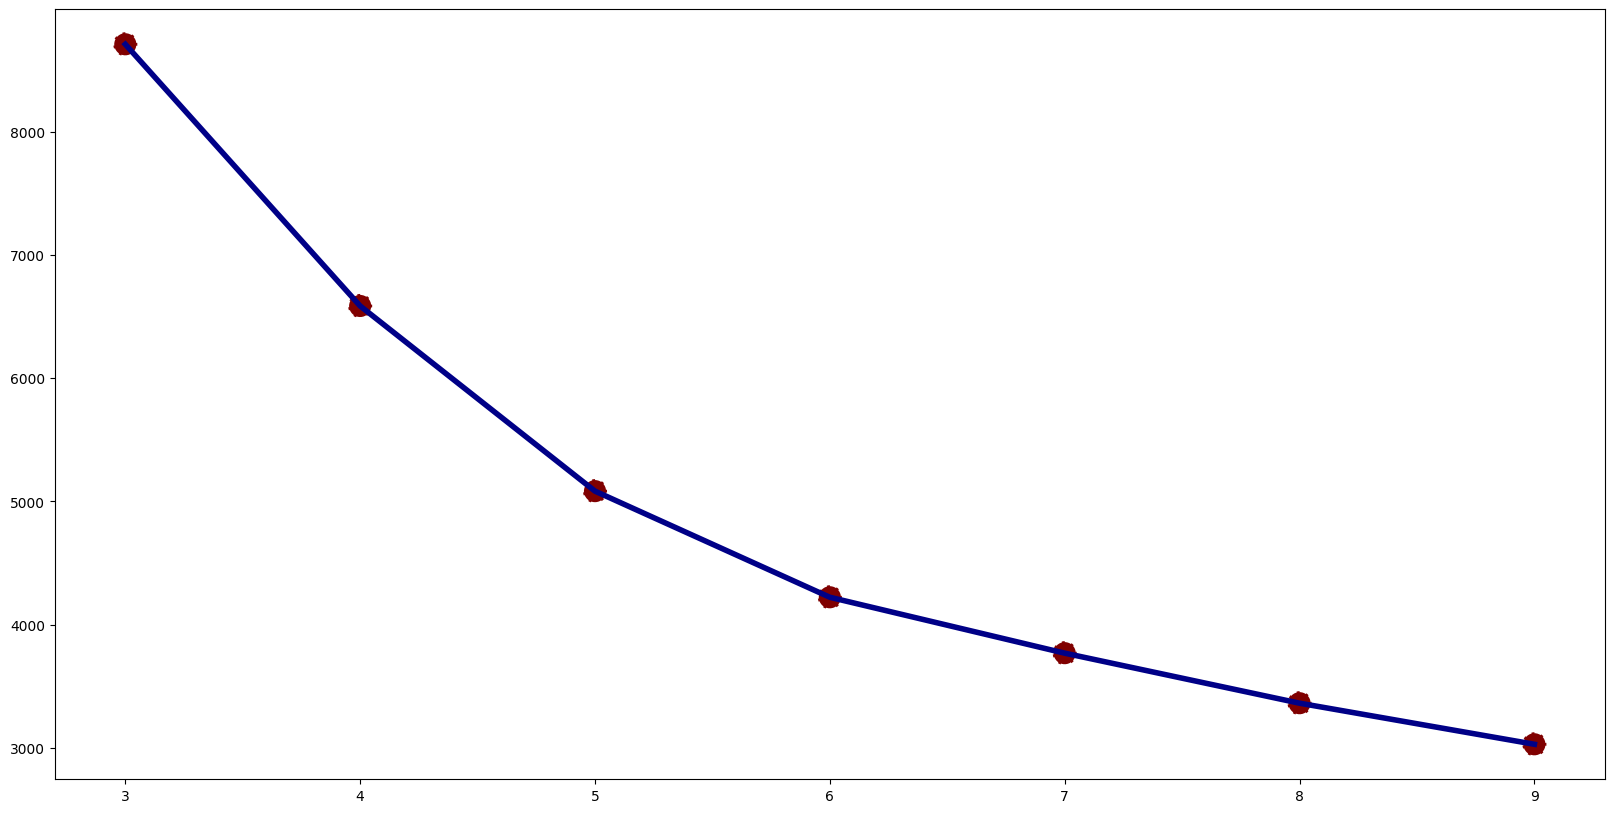

In [ ]:
from sklearn.cluster import KMeans
inertia = []

for i in range(3, 10):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X_std)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(20, 10))

sns.lineplot(x=range(3, 10), y=inertia, color='#000087', linewidth = 4)
sns.scatterplot(x=range(3, 10), y=inertia, s=300, color='#800000',  linestyle='--')


In [ ]:
perc = [0.1,0.2,0.3,00.4,0.5,0.6,0.7,0.8,0.9]
dataset.describe(percentiles=perc)

,Frequency_Order,Frequency_Cancel,monetary,recency
count,4372.000000,4372.000000,4372.000000,4372.000000
mean,4.239707,0.835773,2032.755923,94.047118
std,7.685252,2.137575,8952.025481,100.765435
min,0.000000,0.000000,0.000000,3.000000
10%,1.000000,0.000000,151.307000,7.000000
20%,1.000000,0.000000,241.196000,13.000000
30%,1.000000,0.000000,344.042000,24.000000
40%,2.000000,0.000000,480.790000,34.000000
50%,2.000000,0.000000,659.435000,52.000000
60%,3.000000,0.000000,923.772000,73.000000


## Modeling and Evaluation with RFM + all data




### Scaling

In [ ]:
feat=['recency','Frequency_Order','Frequency_Cancel','monetary']
data_rfm=dataset[feat].copy()
data_rfm.head()

,recency,Frequency_Order,Frequency_Cancel,monetary
0,3,201,47,143711.17
1,4,124,45,40519.84
2,3,93,35,12076.15
3,5,55,31,8507.13
4,3,91,27,60632.75


In [ ]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(data_rfm)

In [ ]:
feats = list(dataset)
new_df = pd.DataFrame(data = X_std, columns = feat)
new_df.head()

,recency,Frequency_Order,Frequency_Cancel,monetary
0,-0.903658,25.605251,21.599015,15.828219
1,-0.893733,15.584914,20.663268,4.299752
2,-0.903658,11.550753,15.984534,1.122041
3,-0.883808,6.605652,14.113040,0.723313
4,-0.903658,11.290485,12.241546,6.546753


### Best K

<Axes: >

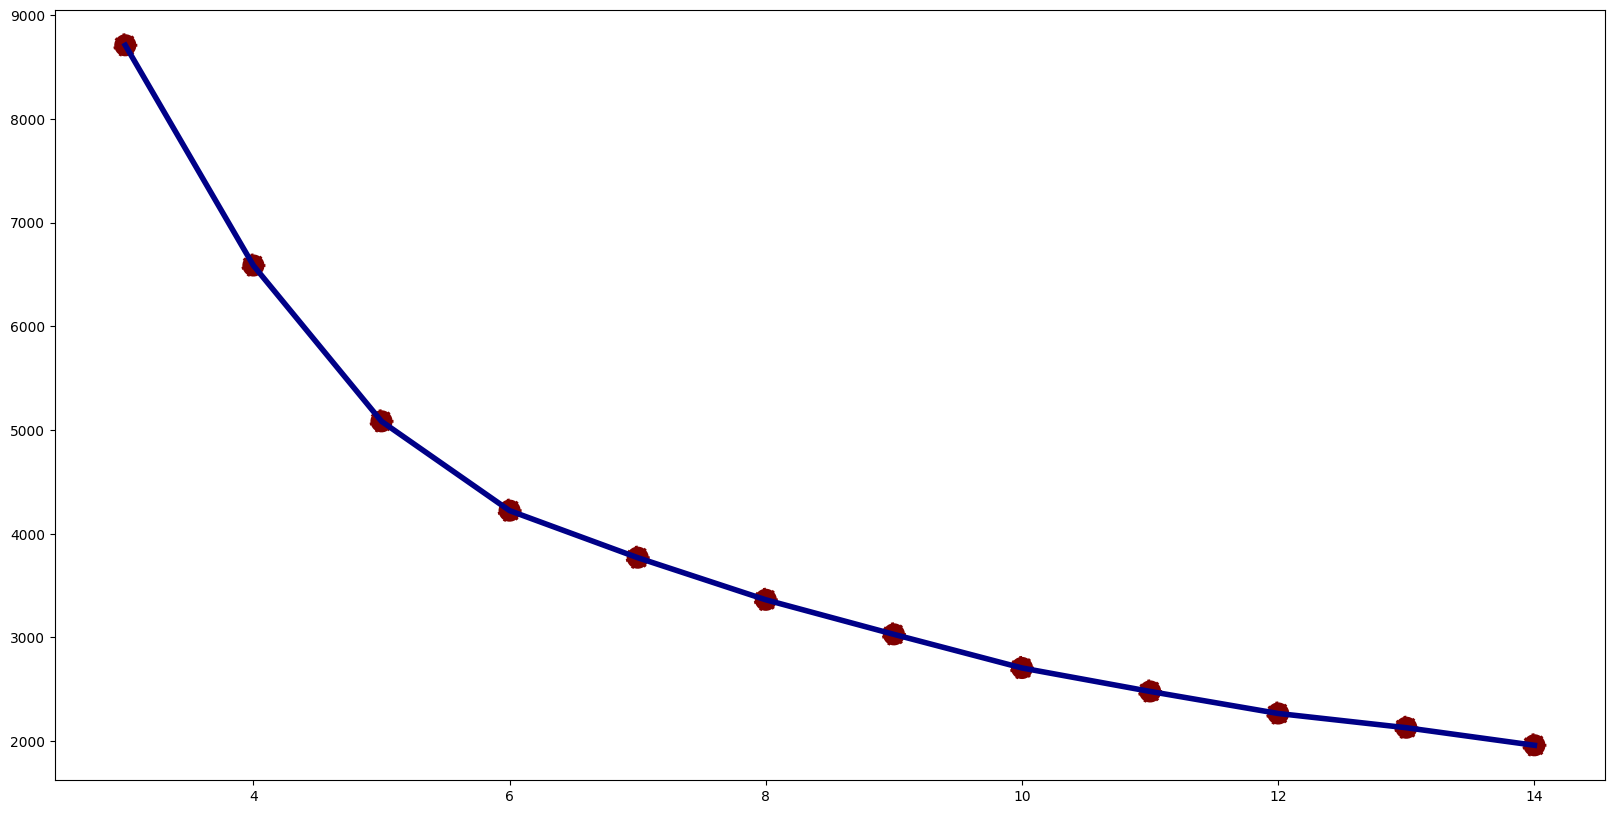

In [ ]:
from sklearn.cluster import KMeans
inertia = []

for i in range(3, 15):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X_std)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(20, 10))

sns.lineplot(x=range(3, 15), y=inertia, color='#000087', linewidth = 4)
sns.scatterplot(x=range(3, 15), y=inertia, s=300, color='#800000',  linestyle='--')


### Clustering

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(X_std)

KMeans(n_clusters=5, random_state=0)

In [ ]:
dataset['clusters'] = kmeans.labels_
dataset.head()

,Frequency_Order,Frequency_Cancel,monetary,recency,clusters
0,201,47,143711.17,3,1
1,124,45,40519.84,4,1
2,93,35,12076.15,3,1
3,55,31,8507.13,5,1
4,91,27,60632.75,3,1


In [ ]:
retail.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [ ]:
retail['Quantity'] = retail['Quantity'].apply(lambda x: 0 if x < 0 else x)

In [ ]:
dataset['CustomerID'] = CustomerID

In [ ]:
def data_cluster():
    q='''
        select
            dt.clusters,
            da.*
        from retail da
        join dataset dt on da.CustomerID=dt.CustomerID

    '''
    return q


data_cluster = ps.sqldf(data_cluster())
data_cluster.head(3)

,clusters,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,2,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00.000000,2.55,17850.0,United Kingdom
1,2,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00.000000,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00.000000,2.75,17850.0,United Kingdom


In [ ]:
data_cluster.describe()

,clusters,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000,401604.000000
mean,0.884882,12.863134,3.474064,15281.160818
std,1.242949,179.581848,69.764035,1714.006089
min,0.000000,0.000000,0.000000,12346.000000
25%,0.000000,2.000000,1.250000,13939.000000
50%,0.000000,5.000000,1.950000,15145.000000
75%,2.000000,12.000000,3.750000,16784.000000
max,4.000000,80995.000000,38970.000000,18287.000000


## EDA

### Univariate Analysis

In Univariate Analysis, the following will be displayed:
1. Boxplot
2. KDE Plot (Kernel Density Estimate Plot)



In [ ]:
# membagi nama kolom berdasarkan tipe datanya
numericals = data_cluster.select_dtypes(include=['int64','float64']).columns.tolist()
categoricals = data_cluster.select_dtypes(exclude=['int64','float64']).columns.tolist()

print(f"numericals columns are {numericals}")
print(f"categoricals columns are {categoricals}")

numericals columns are ['clusters', 'Quantity', 'UnitPrice', 'CustomerID']
categoricals columns are ['InvoiceNo', 'StockCode', 'Description', 'InvoiceDate', 'Country']


#### Boxplot to detect outliers

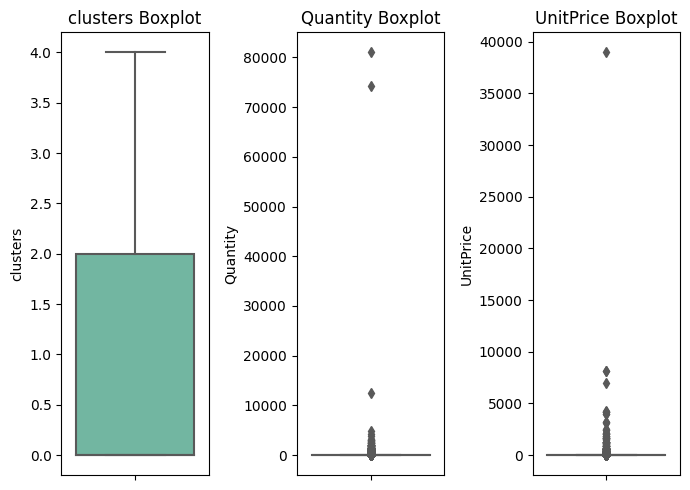

In [ ]:
numericals = ['clusters', 'Quantity', 'UnitPrice']
# adjust the figure size for better readability
plt.figure(figsize=(7,5))

# plotting
features = numericals

features = numericals
for i in range(0, len(features)):
    plt.subplot(len(features)//2, 3, i+1)
    sns.boxplot(y=data_cluster[features[i]], palette='Set2')
    plt.title("{} Boxplot".format(features[i]))
    plt.tight_layout()

Observation:
1. Ada outlier di kolom Quantity, dan UnitPrice .

2. Outlier masih wajar sehingga tidak akan kita hapus



#### KDE plot

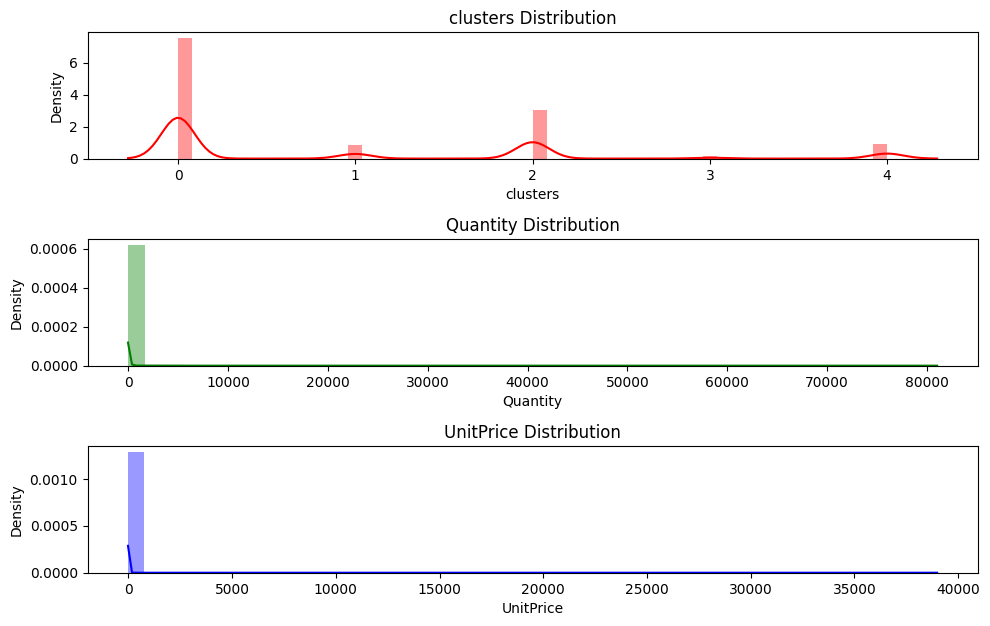

In [ ]:
import colorsys
# adjust the figure size for better readability

plt.figure(figsize=(10,8))

feat_num=numericals
colors=['red','green','blue']
for i in range(0, len(feat_num)):
    plt.subplot(4, len(feat_num)//3, i+1)
    sns.distplot(x=data_cluster[feat_num[i]], color=colors[i % len(colors)])
    plt.xlabel(feat_num[i])
    plt.title("{} Distribution".format(feat_num[i]))
    plt.tight_layout()

Observation:

1. There are no columns indicating a normal or symmetric distribution.





**Top 5 Country with the Most Purchases**

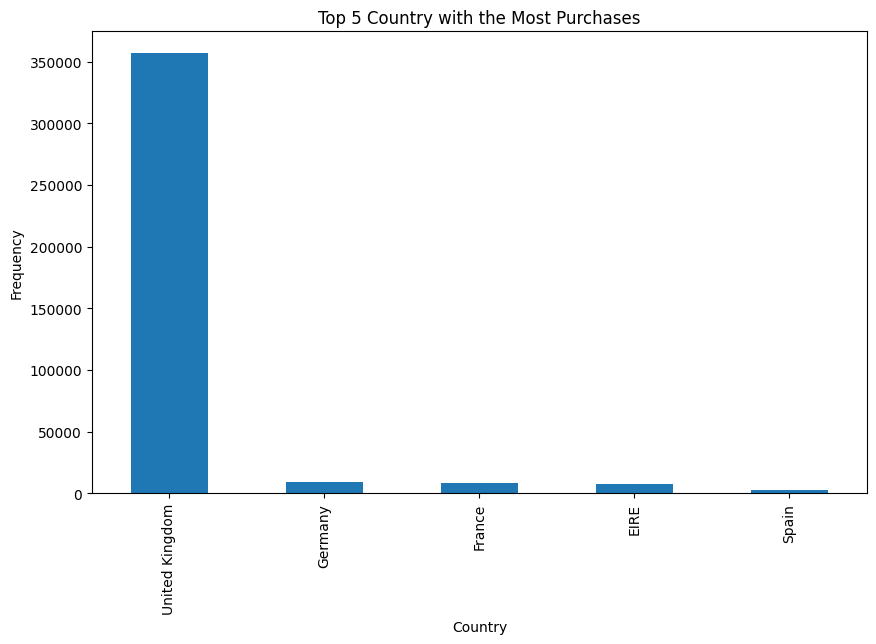

In [ ]:
country_counts = data_cluster['Country'].value_counts().head(5)

plt.figure(figsize=(10, 6))
country_counts.plot(kind='bar')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.title('Top 5 Country with the Most Purchases')
plt.show()

Observation:

Country yang paling banyak melakukan pembelian berasal dari UK. Dan adanya perbedaan / terjadi ketimpangan yang sangat jauh dibabnding negara lain dimana negara lain memiliki frequency yang jauh lebih rendah.

Karena UK memiliki frekuensi pembelian yang jauh lebih tinggi, kita bisa coba untuk mempertahankan dan memperkuat hubungan dengan pelanggan di negara tersebut dengan memberikan penawaran khusus, diskon, atau program loyalitas kepada pelanggan UK untuk mendorong pembelian lebih lanjut dan mempertahankan loyalitas mereka.

Kita juga bisa analisa negara lain untuk menjadi acuan apakah ada kebutuhan atau preferensi yang bisa kita penuhi untuk mengembangkan strategi pemasaran di negara lain

#### Preprocessing

In [ ]:
# Mengubah kolom "InvoiceDate" menjadi tipe datetimelike
data_cluster['InvoiceDate'] = pd.to_datetime(data_cluster['InvoiceDate'])

# Membuat kolom "Month" yang berisi nama bulan
data_cluster['Month'] = data_cluster['InvoiceDate'].dt.month_name()

# Membuat kolom "Day" yang berisi nama hari
data_cluster['Day'] = data_cluster['InvoiceDate'].dt.day_name()

# Membuat kolom "Year" yang berisi tahun
data_cluster['Year'] = data_cluster['InvoiceDate'].dt.year

# Membuat kolom "Hour" yang berisi jam
data_cluster['Hour'] = data_cluster['InvoiceDate'].dt.hour

In [ ]:
data_cluster['Month_code'] = data_cluster['InvoiceDate'].dt.month
data_cluster['Day_code'] = data_cluster['InvoiceDate'].dt.weekday+1

In [ ]:
data_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401604 entries, 0 to 401603
Data columns (total 15 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   clusters     401604 non-null  int64         
 1   InvoiceNo    401604 non-null  object        
 2   StockCode    401604 non-null  object        
 3   Description  401604 non-null  object        
 4   Quantity     401604 non-null  int64         
 5   InvoiceDate  401604 non-null  datetime64[ns]
 6   UnitPrice    401604 non-null  float64       
 7   CustomerID   401604 non-null  float64       
 8   Country      401604 non-null  object        
 9   Month        401604 non-null  object        
 10  Day          401604 non-null  object        
 11  Year         401604 non-null  int64         
 12  Hour         401604 non-null  int64         
 13  Month_code   401604 non-null  int64         
 14  Day_code     401604 non-null  int64         
dtypes: datetime64[ns](1), float64(2), 

**Purchase Trend by Month**

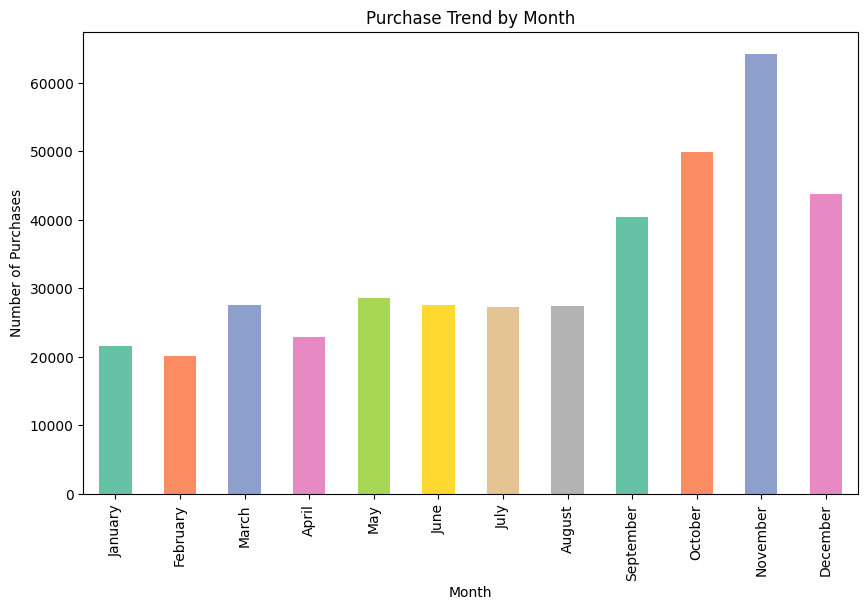

In [ ]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

purchase_by_month = data_cluster['Month'].value_counts().loc[month_order]

colors = sns.color_palette("Set2")
plt.figure(figsize=(10, 6))
purchase_by_month.plot(kind='bar', color=colors)
plt.xlabel('Month')
plt.ylabel('Number of Purchases')
plt.title('Purchase Trend by Month')
plt.show()


Observation:
 Terjadi perbedaan tren dimana terjadi kenaikan pada bulan September-November (Akhir Tahun). Di bulan Desember juga masih dibilang tinggi dibanding bulan-bulan awal.

 Kenaikan tren di akhir tahun mungkin disebabkan karena adanya musim liburan disertai banyaknya perayaan di akhir tahun seperti Natal, Thanksgiving, Black Friday maupun Tahun Baru. Perusahaan dapat memanfaatkan momen ini dengan menawarkan penawaran khusus, diskon, atau paket promosi yang sesuai dengan semangat musim liburan.

**Purchase Trend by Day**

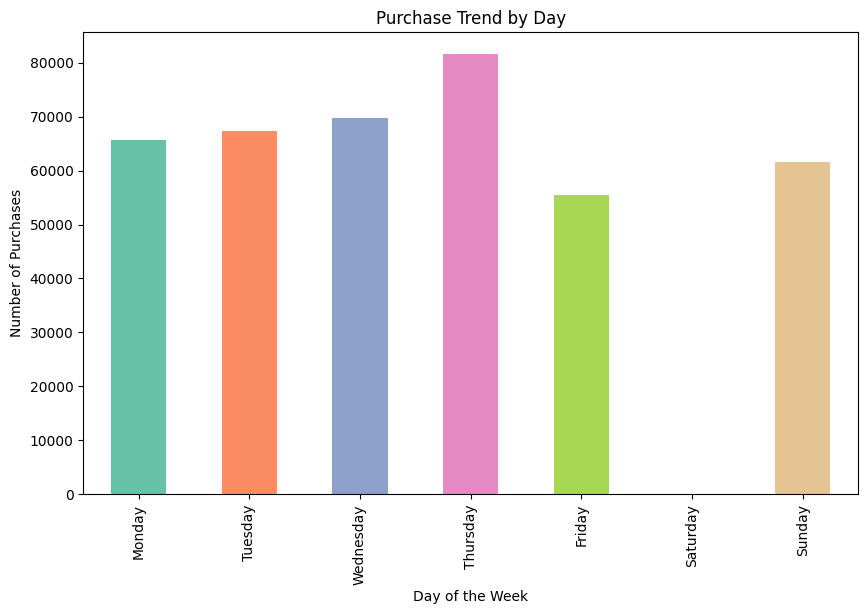

In [ ]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# data_cluster['Day'] = pd.Categorical(data_cluster['Day'], categories=day_order, ordered=True)

# Menghitung frekuensi pembelian berdasarkan hari
purchase_by_day = data_cluster['Day'].value_counts().reindex(day_order)

colors = sns.color_palette("Set2")

plt.figure(figsize=(10, 6))
purchase_by_day.plot(kind='bar',color=colors)
plt.xlabel('Day of the Week')
plt.ylabel('Number of Purchases')
plt.title('Purchase Trend by Day')
plt.show()

In [ ]:
data_cluster['Day'].unique()

array(['Wednesday', 'Thursday', 'Friday', 'Sunday', 'Monday', 'Tuesday'],
      dtype=object)

Observation:

Kita tidak menemukan data Hari Sabtu di dalam dataset. Ini memungkinkan bahwa semua toko tutup pada hari Sabtu.
Pembelian tertinggi terjadi pada hari Kamis dan pembelian yang terendah terjadi pada hari jumat.

Dengan mengetahui bahwa pembelian lebih tinggi pada hari Kamis, Perusahaan dapat mengatur strategi promosi dan penawaran khusus untuk menarik pelanggan pada hari tersebut.

**Purchase Trend by Hour**

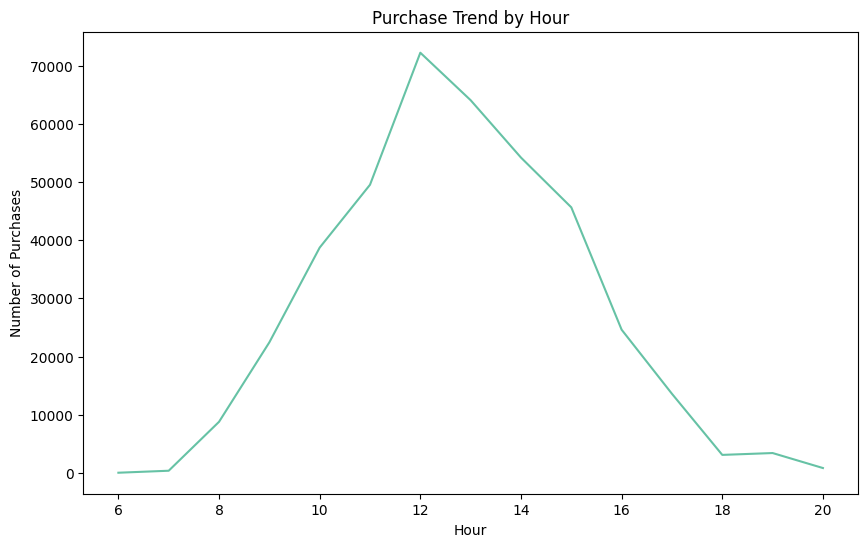

In [ ]:
# Analisis tren pembelian produk berdasarkan jam
purchase_by_hour = data_cluster.groupby('Hour')['InvoiceNo'].count()

colors = sns.color_palette("Set2")

plt.figure(figsize=(10, 6))
purchase_by_hour.plot(kind='line',color=colors)
plt.xlabel('Hour')
plt.ylabel('Number of Purchases')
plt.title('Purchase Trend by Hour')
plt.show()

Observation:

Jumlah purchase tertinggi berada di jam-jam sianng / waktu menjelang istirahat dan puncaknya berada di jam 12.

Berdasarkan tren pembelian pada jam-jam siang, Perusahaan dapat mengerahkan upaya promosi dan pemasaran pada jam-jam ini. Misalnya, mengirimkan notifikasi atau penawaran khusus kepada pelanggan pada jam-jam ini atau memberikan diskon khusus untuk produk yang populer pada jam-jam siang.

### Bivariate Analysis

Text(0.5, 1.0, 'Purchase Trend by Cluster in November')

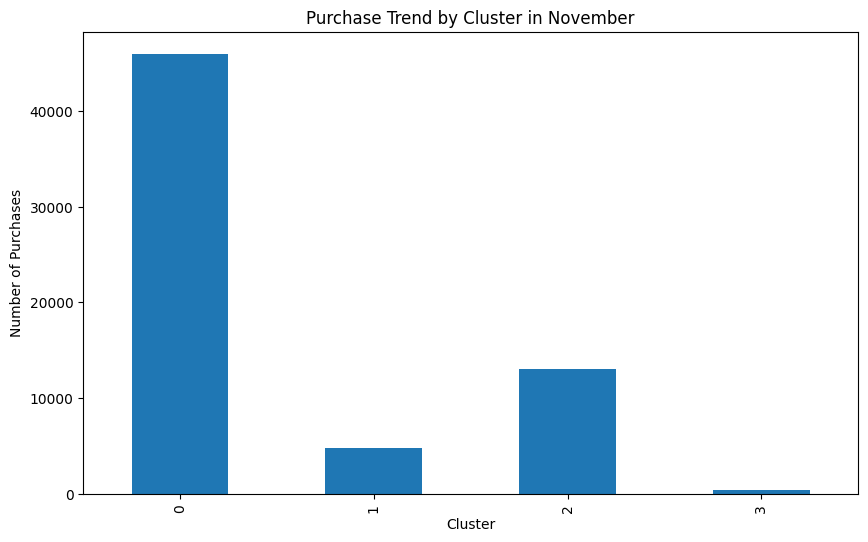

In [ ]:
# Filter data untuk bulan November
data_november = data_cluster[data_cluster['Month'] == 'November']

# Kelompokkan data bulan November berdasarkan kolom "clusters" dan hitung jumlah pembelian per cluster
purchase_by_cluster_november = data_november.groupby('clusters')['InvoiceNo'].count()


plt.figure(figsize=(10, 6))
purchase_by_cluster_november.plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Number of Purchases')
plt.title('Purchase Trend by Cluster in November')

Observation:

Setelah mengetahui sebelumya bahwa bulan November adalah bulan yang paling banyak pembelian. Kita juga mengetahui ternyata pada bulan November ini, pembelian didominasi oleh customer dari cluster 0 dan diikuti oleh customer cluster 2. Dan tidak ada pembelian dari customer cluster 4

In [ ]:
november_data = data_cluster[data_cluster['Month'] == 'November']

**Top Customer based Total Purchases**

In [ ]:

# Menghitung total pembelian per customer pada bulan November
purchase_by_customer = november_data.groupby(['CustomerID','clusters'])['InvoiceNo'].nunique().sort_values(ascending=False)


top_customer = pd.DataFrame(purchase_by_customer.head(10))

top_customer = top_customer.rename(columns={'CustomerID': 'Customer ID', 'InvoiceNo': 'Total Purchases'})

top_customer

,,Total Purchases
CustomerID,clusters,
12748.0,1,48
14911.0,1,40
17841.0,1,22
15311.0,1,13
12971.0,2,13
14606.0,1,13
14646.0,3,12
17450.0,3,11
14156.0,3,10


Observation:
3 Top customer berasal dari cluster 1 dengan total purchases tertinggi sebanyak 48. Kita bisa memeberikancustomer-customer  tersebut dengan melakukan penawaran dan service terbaik agar meningkatkan jumlah purchase di perusahaan

**Purchase Trend by Cluster**

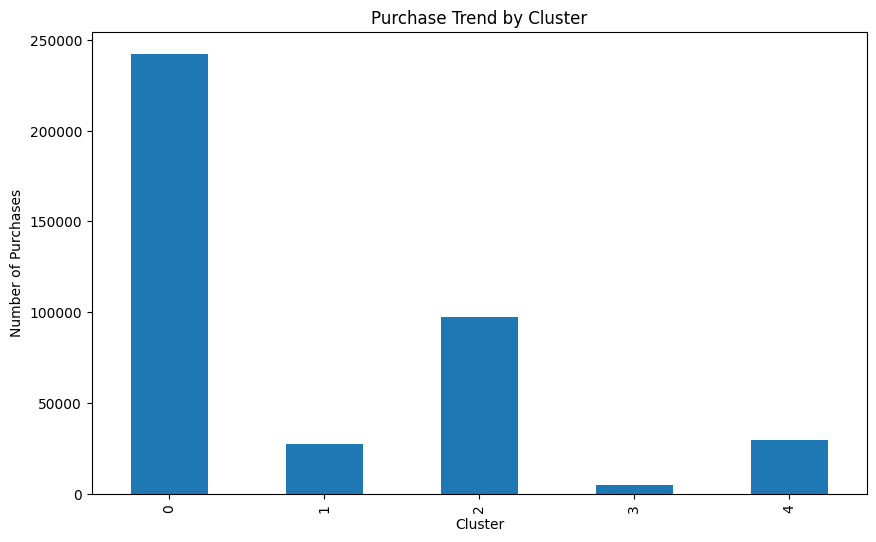

In [ ]:
# Kelompokkan data berdasarkan kolom "clusters" dan hitung jumlah pembelian per cluster
purchase_by_cluster = data_cluster.groupby('clusters')['InvoiceNo'].count()

# Visualisasikan tren pembelian per cluster menggunakan grafik bar
plt.figure(figsize=(10, 6))
purchase_by_cluster.plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Number of Purchases')
plt.title('Purchase Trend by Cluster')
plt.show()

Observation:

Purchases tertinggi berada di cluster 0, diikuti cluster 2 dan 3.Dan pembelian terendah berada di cluster 3. Ini menarik karena sebelumnya top customer tertinggi berasal dari cluster 1 namun total pembelian tidak lebih tinggi dari cluster 2. Kita bisa memberikan penawaran terbaik atau melakukan strategi bisnis untuk membuat customer di cluster 1 meningkatkan pembelian. Selain itu, pada cluster 3 harus kita beri perhatian agar menemukan strategi yang bisa meningkatkan minat belanja

**Clusters with Discounts**

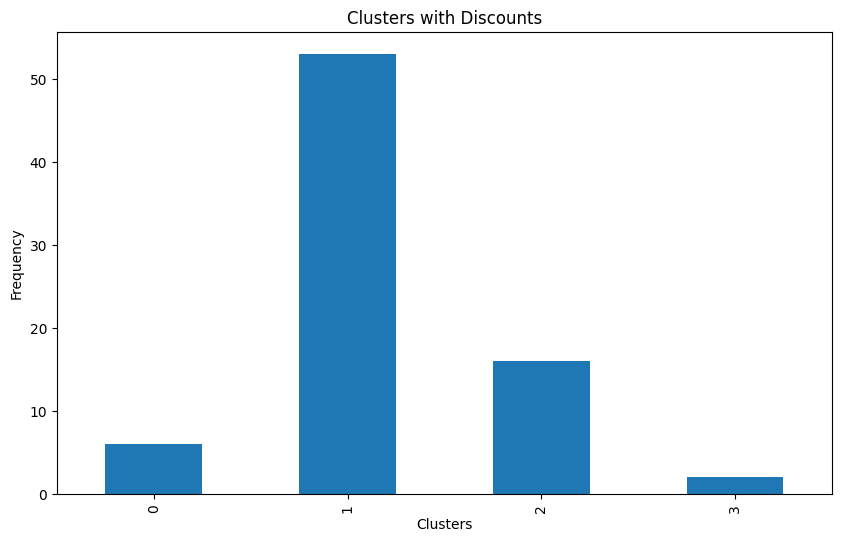

In [ ]:

discount_data = data_cluster[data_cluster['StockCode'] == 'D']

# Menghitung frekuensi setiap cluster
cluster_counts = discount_data['clusters'].value_counts()

# Mengurutkan cluster berdasarkan indeks (nilai cluster) secara numerik
cluster_counts = cluster_counts.reindex(sorted(cluster_counts.index))


plt.figure(figsize=(10, 6))
cluster_counts.plot(kind='bar')
plt.xlabel('Clusters')
plt.ylabel('Frequency')
plt.title('Clusters with Discounts')

plt.show()


Observation:

Cluster 0 adalah customer yang memiliki frequnecy tertinggi dalam minat untuk membeli produk diskon dibanding cluster lain.

Sebaliknya, cluster 4 tidak memiliki minat untuk membeli produk diskon dan tidak ada sama sekali yang membeli produk diskon.

Cluster 0 menunjukkan minat yang tinggi terhadap pembelian produk diskon. Ini dapat dijadikan sebagai peluang untuk mengembangkan strategi pemasaran yang lebih fokus pada penawaran diskon kepada pelanggan dalam Cluster 0.

Ini bisa jadi disebabkan oleh perbedaan preferensi, mungkin saja kita bisa meberikan cluster 0 penawaran diskon yang lebih spesifik, sementara untuk pelanggan dalam Cluster 4, dapat menyesuaikan strategi pemasaran yang lebih fokus pada nilai produk atau faktor-faktor lain yang menjadi motivasi mereka dalam pembelian.

### Multivariate Analysis

#### Correlation Matrix

<Axes: >

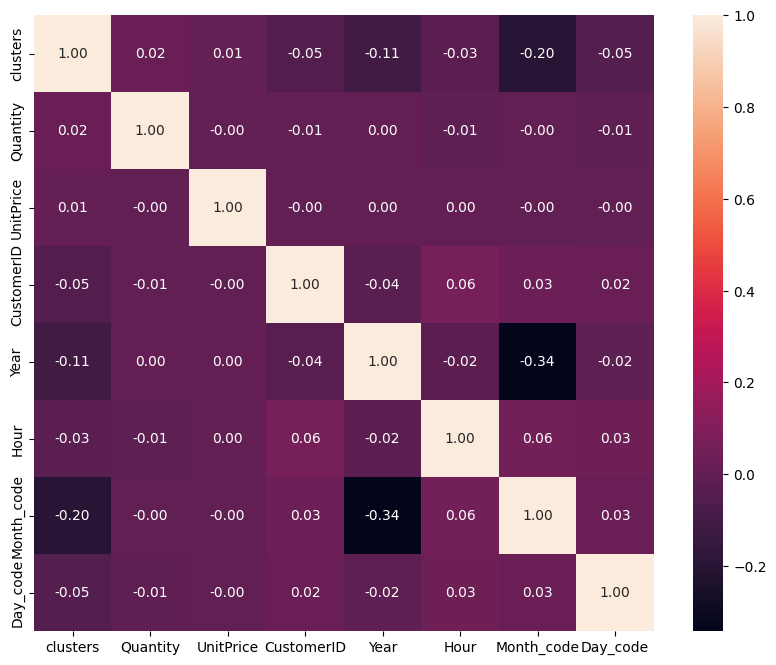

In [ ]:
corr_= data_cluster.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_, annot=True, fmt = ".2f")

Tidak ada variabel yang saling berkorelasi tinggi

## Cluster Analysis

In [ ]:
dataset.groupby('clusters').agg({
                            'recency' : ['mean'],
                            'Frequency_Order' : ['mean'],
                            'Frequency_Cancel' : ['mean'],
                            'monetary' : ['mean']

})

,recency,Frequency_Order,Frequency_Cancel,monetary
,mean,mean,mean,mean
clusters,,,,
0,45.463618,3.563084,0.524366,1297.751944
1,9.000000,104.700000,27.600000,50091.459000
2,17.685315,17.293706,5.101399,9575.720105
3,9.666667,43.000000,5.166667,190808.536667
4,251.172253,1.499069,0.295158,572.367142


0 : customer with need attention <br>
1 : potential loyal customer <br>
2 : reguler customer <br>
3 : loyal customer <br>
4 : potential **lost customer**

Cluster 0: "Customer with need attention".

Pelanggan dalam cluster ini memiliki tingkat pembelian yang rendah dengan frekuensi order yang rendah. Mereka adalah pelanggan yang hanya berbelanja pada waktu tertentu. Kemungkinan hanya berbelanja jika hanya ada diskon mengingat distribusi diskon tertinggi berada di cluster 0.

Saran Peningkatan:
* Menyediakan pengalaman belanja yang lebih menarik dan relevan untuk menarik minat pelanggan dalam cluster ini.
* Mengirimkan pengingat atau notifikasi kepada pelanggan dalam cluster ini tentang produk atau penawaran baru yang mungkin menarik minat mereka.

Cluster 1: "potential loyal customer".

Pelanggan dalam cluster ini memiliki tingkat pembelian yang tinggi dengan frekuensi order yang sangat tinggi, tetapi juga memiliki tingkat pembatalan yang tinggi.

Saran Peningkatan:
* Melakukan analisis lebih mendalam mengenai alasan di balik tingginya tingkat pembatalan dan mengambil tindakan untuk menguranginya, seperti meningkatkan kualitas layanan pelanggan.
* Menawarkan insentif tambahan atau keuntungan ekstra kepada pelanggan dalam cluster ini untuk mendorong mereka agar tidak membatalkan pesanan.
* Membangun program loyalitas yang menarik bagi pelanggan dalam cluster ini untuk mempertahankan kesetiaan mereka.

Cluster 2: 'Reguler Customer'.

Pelanggan dalam cluster ini memiliki tingkat pembelian yang sedang dengan frekuensi order yang sedang. Sepertinya mereka adalah pelanggan yang secara teratur melakukan pembelian.

Saran Peningkatan:
* Meningkatkan interaksi dan komunikasi dengan pelanggan dalam cluster ini melalui email, pemberitahuan, atau pesan personal untuk menjaga keterlibatan mereka.
* Menawarkan program reward atau diskon eksklusif kepada pelanggan dalam cluster ini sebagai bentuk apresiasi dan insentif agar mereka tetap berbelanja secara teratur.
* Mengidentifikasi preferensi dan minat pelanggan dalam cluster ini untuk menawarkan produk atau layanan yang sesuai dengan kebutuhan mereka.

Cluster 3: 'Loyal Customer'

Pelanggan dalam cluster ini memiliki tingkat pembelian yang sedang dengan frekuensi order yang cukuo tinggi, serta nilai pembelian yang tinggi. Mereka adalah pelanggan yang memberikan kontribusi besar bagi perusahaan.

Saran Peningkatan:
* Memberikan pengalaman pelanggan yang ekstra kepada pelanggan dalam cluster ini untuk mempertahankan loyalitas mereka.
* Menyediakan layanan pelanggan yang cepat dan responsif kepada pelanggan dalam cluster ini.
* Menawarkan produk atau layanan tambahan yang relevan untuk meningkatkan nilai rata-rata pembelian dari pelanggan dalam cluster ini.

Cluster 4: 'Potential lost customer'

Pelanggan dalam cluster ini memiliki tingkat pembelian yang rendah dengan frekuensi yang rendah. Mereka jarang berbelanja.

Saran Peningkatan:
* Mengirimkan penawaran khusus atau diskon yang menarik kepada pelanggan dalam cluster ini untuk mendorong mereka agar berbelanja lebih sering.
* Meningkatkan kesadaran pelanggan dalam cluster ini tentang produk atau layanan yang ditawarkan melalui kampanye pemasaran yang efektif.
* Menyediakan pengalaman belanja yang lebih menarik dan relevan untuk menarik minat pelanggan dalam cluster ini.


### Cluster Distribution

In [ ]:
dist_cluster = dataset.groupby('clusters').agg({
    'CustomerID' : ['count']

}).reset_index()
dist_cluster.columns = ['clusters','total customer']
dist_cluster

,clusters,total customer
0,0,2996
1,1,10
2,2,286
3,3,6
4,4,1074


In [ ]:
# kemungkinan / bisa jadi cluster 1 dan 3 adalah outlier

<Axes: xlabel='clusters', ylabel='total customer'>

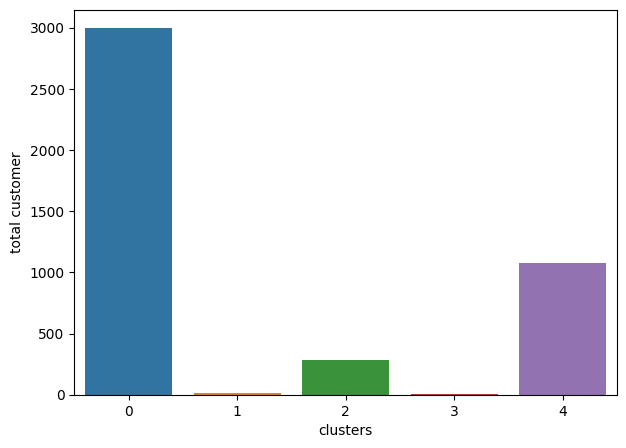

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
sns.barplot(x='clusters', y='total customer', data=dist_cluster)

dari graph diatas, mayoritas user berada di cluster 0<br>
<!-- 0 : hibernating<br>
2 : recent customers atau new customers<br>
4 : lost customers<br>
6 : customers with need attention<br> -->

0 : customer with need attention <br>
1 : potential loyal customer <br>
2 : reguler customer <br>
3 : loyal customer <br>
4 : potential **lost customer**

**artinya, online retail tersebut sedang TIDAK BAIK BAIK SAJA, karena di dominasi oleh user "tidak produktif"**
**artinya, online retail tersebut mendapatkan cluster terbanyak di cluster 0 yang merupakan customer need attention. Selain itu jumlah customer yang berpotensi hilang juga cukup banyak sehingga dapat dikatakan bahwa perusahaan harus lebih 'BERHATI-HATI' dan warning dengan kemungkinan lebih banyak user yang "tidak produktif" kedepannya karena jumlah potential loyal customer lebih sedikit dibandingkan lost customer**

### End Customer - country

In [ ]:
def data_country():
    q='''
        select
            clusters,
            Country,
            count(distinct CustomerID) as total_end_cust
        from data_cluster
        group by 1, 2
        order by 1, 3 desc

    '''
    return q


data_country = ps.sqldf(data_country())
data_country.head(3)

,clusters,Country,total_end_cust
0,0,United Kingdom,2715
1,0,Germany,64
2,0,France,60


In [ ]:
data_country.head()

,clusters,Country,total_end_cust
0,0,United Kingdom,2715
1,0,Germany,64
2,0,France,60
3,0,Spain,24
4,0,Switzerland,16


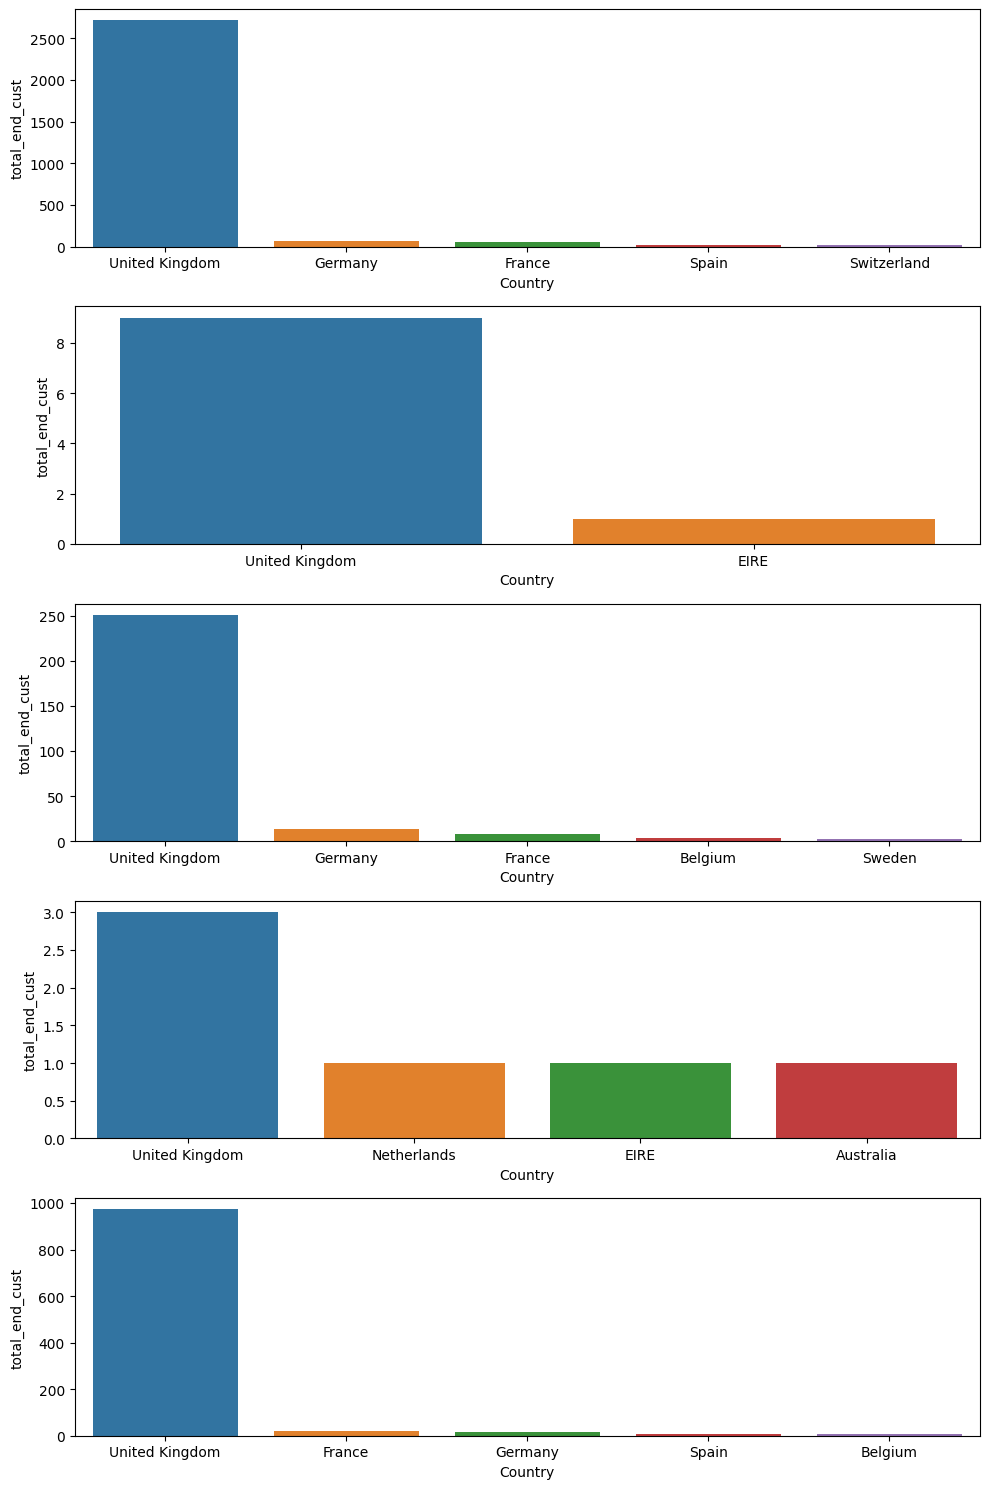

In [ ]:
fig,ax = plt.subplots(5,1,figsize=(10,15))

sns.barplot(x='Country', y='total_end_cust', data=data_country[data_country['clusters']==0][0:5], ax=ax[0])
sns.barplot(x='Country', y='total_end_cust', data=data_country[data_country['clusters']==1][0:5], ax=ax[1])
sns.barplot(x='Country', y='total_end_cust', data=data_country[data_country['clusters']==2][0:5], ax=ax[2])
sns.barplot(x='Country', y='total_end_cust', data=data_country[data_country['clusters']==3][0:5], ax=ax[3])
sns.barplot(x='Country', y='total_end_cust', data=data_country[data_country['clusters']==4][0:5], ax=ax[4])
# sns.barplot(x='Country', y='total_end_cust', data=data_city[data_city['clusters']==6][0:5], ax=ax[5])
plt.tight_layout()

In [ ]:
# Setiap cluster kebanyakan berasal dari UK namun disetiap cluster memiliki perbedaan pola sehingga bisa kita jadikan acuan

### End Customer - Product / Description

In [ ]:
data_cluster.head(3)

,clusters,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,Day,Year,Hour,Month_code,Day_code
0,2,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,December,Wednesday,2010,8,12,3
1,2,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,December,Wednesday,2010,8,12,3
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,December,Wednesday,2010,8,12,3


In [ ]:
def data_product():
    q='''
        select
            clusters,
            Description,
            count(distinct CustomerID) as total_end_cust
        from data_cluster
        group by 1, 2
        order by 1, 3 desc

    '''
    return q


data_p = ps.sqldf(data_product())
data_p.head(3)

,clusters,Description,total_end_cust
0,0,REGENCY CAKESTAND 3 TIER,584
1,0,WHITE HANGING HEART T-LIGHT HOLDER,575
2,0,PAPER CHAIN KIT 50'S CHRISTMAS,493


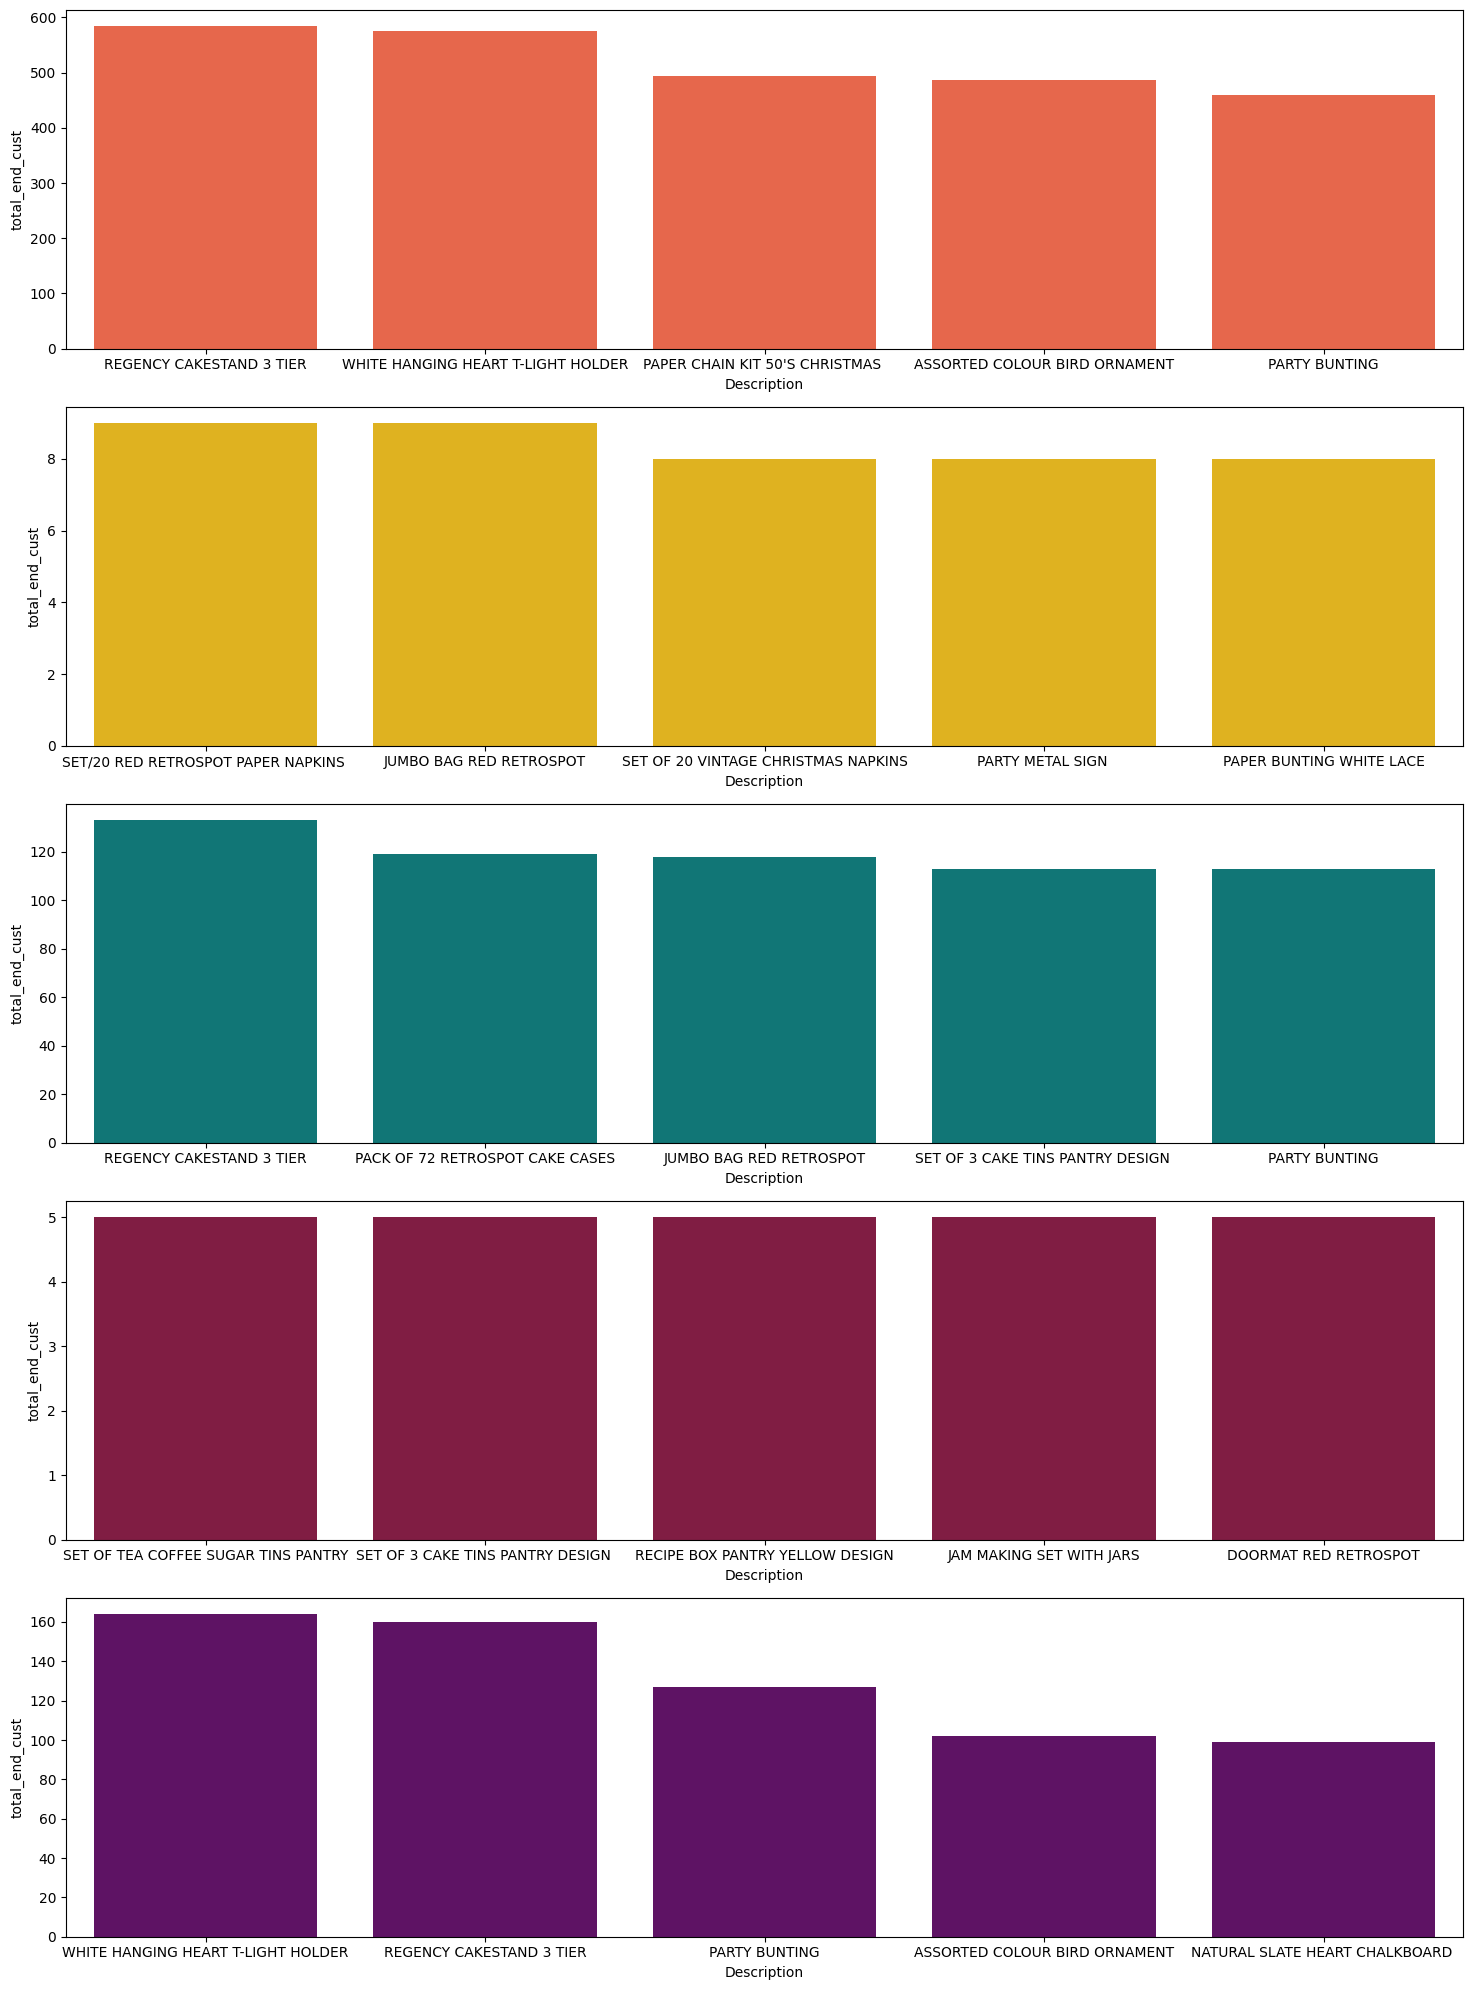

In [ ]:
fig,ax = plt.subplots(5,1,figsize=(15,20))

sns.barplot(x='Description', y='total_end_cust', data=data_p[data_p['clusters']==0][0:5], ax=ax[0], color='#FF5733')
sns.barplot(x='Description', y='total_end_cust', data=data_p[data_p['clusters']==1][0:5], ax=ax[1], color='#FFC300')
sns.barplot(x='Description', y='total_end_cust', data=data_p[data_p['clusters']==2][0:5], ax=ax[2], color='#008787')
sns.barplot(x='Description', y='total_end_cust', data=data_p[data_p['clusters']==3][0:5], ax=ax[3], color='#900C3F')
sns.barplot(x='Description', y='total_end_cust', data=data_p[data_p['clusters']==4][0:5], ax=ax[4], color='#6A0572')
# sns.barplot(x='Description', y='total_end_cust', data=data_p[data_p['clusters']==6][0:5], ax=ax[5], color='#008787')
plt.tight_layout()

masing-masing cluster menunjukkan perbedaan rekomendasi product

## End-Product in November

In [ ]:
def data_product_nov():
    q='''
        select
            clusters,
            Description,
            count(distinct CustomerID) as total_end_cust
        from data_cluster
        where Month = 'November'
        group by 1, 2
        order by 1, 3 desc

    '''
    return q


data_n = ps.sqldf(data_product_nov())
data_n.head(3)

,clusters,Description,total_end_cust
0,0,RABBIT NIGHT LIGHT,257
1,0,PAPER CHAIN KIT 50'S CHRISTMAS,218
2,0,HOT WATER BOTTLE KEEP CALM,165


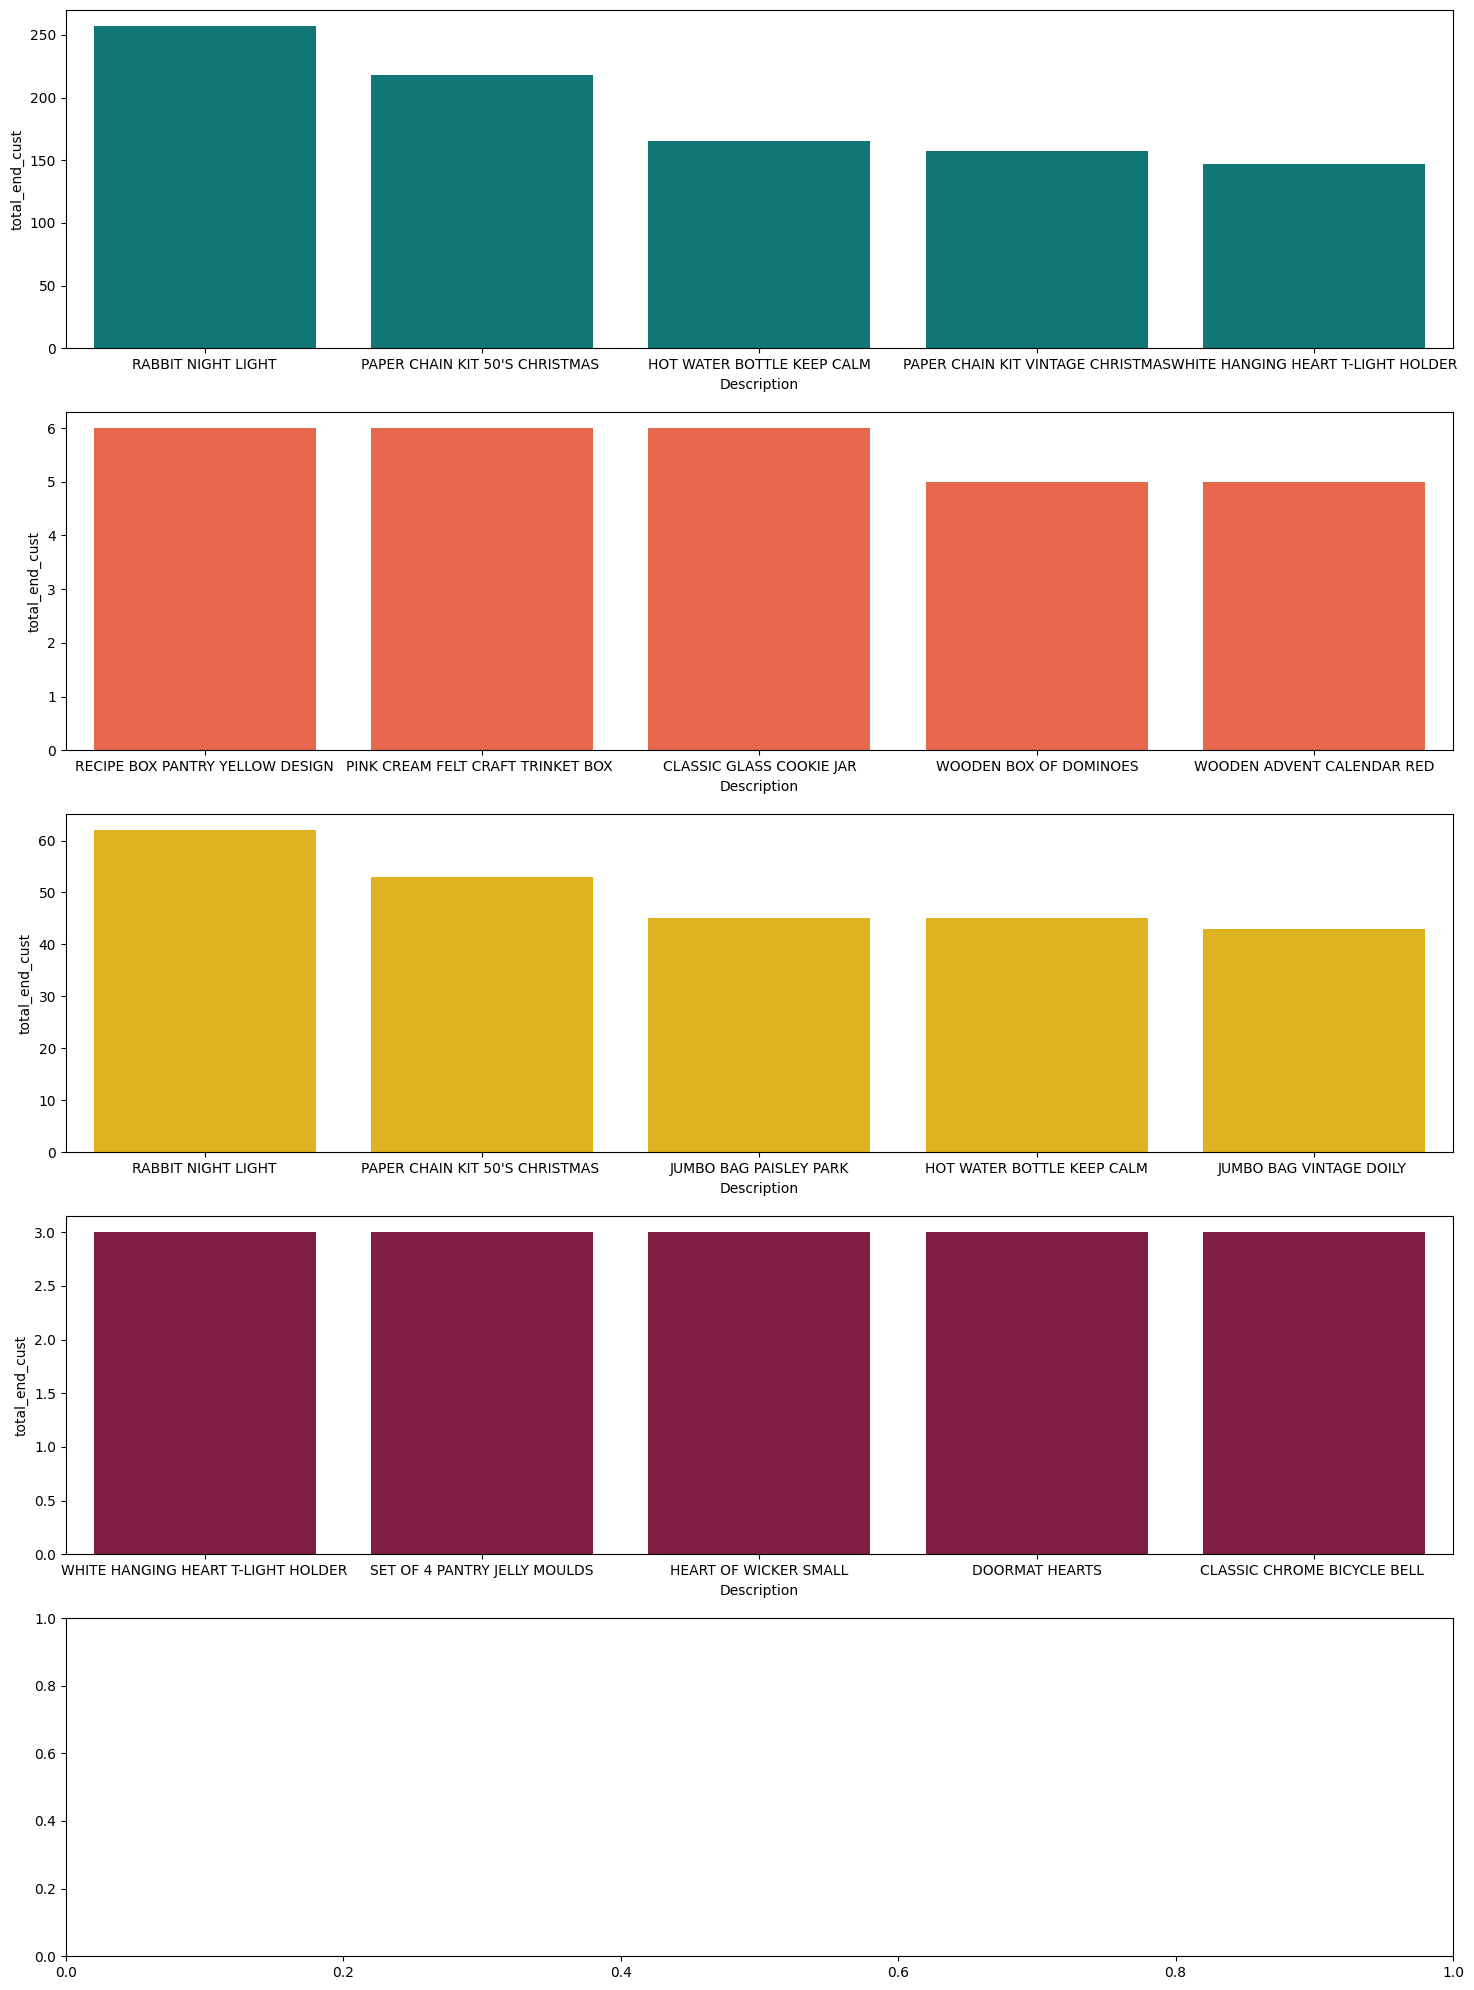

In [ ]:
fig,ax = plt.subplots(5,1,figsize=(15,20))

sns.barplot(x='Description', y='total_end_cust', data=data_n[data_n['clusters']==0][0:5], ax=ax[0], color='#008787')
sns.barplot(x='Description', y='total_end_cust', data=data_n[data_n['clusters']==1][0:5], ax=ax[1], color='#FF5733')
sns.barplot(x='Description', y='total_end_cust', data=data_n[data_n['clusters']==2][0:5], ax=ax[2], color='#FFC300')
sns.barplot(x='Description', y='total_end_cust', data=data_n[data_n['clusters']==3][0:5], ax=ax[3], color='#900C3F')
# sns.barplot(x='Description', y='total_end_cust', data=data_n[data_n['clusters']==4][0:5], ax=ax[4], color='#008787')
# sns.barplot(x='Description', y='total_end_cust', data=data_p[data_p['clusters']==6][0:5], ax=ax[5], color='#008787')
plt.tight_layout()

In [ ]:
data_cluster['day_week'] = data_cluster['Day_code'].apply(lambda x: 'Weekday' if x < 6 else 'Weekend')

In [ ]:
data_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401604 entries, 0 to 401603
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   clusters     401604 non-null  int64         
 1   InvoiceNo    401604 non-null  object        
 2   StockCode    401604 non-null  object        
 3   Description  401604 non-null  object        
 4   Quantity     401604 non-null  int64         
 5   InvoiceDate  401604 non-null  datetime64[ns]
 6   UnitPrice    401604 non-null  float64       
 7   CustomerID   401604 non-null  float64       
 8   Country      401604 non-null  object        
 9   Month        401604 non-null  object        
 10  Day          401604 non-null  object        
 11  Year         401604 non-null  int64         
 12  Hour         401604 non-null  int64         
 13  Month_code   401604 non-null  int64         
 14  Day_code     401604 non-null  int64         
 15  day_week     401604 non-null  obje

## End-Product in Weekend

In [ ]:
def data_product_weekend():
    q='''
         select
            clusters,
            Description,
            count(distinct CustomerID) as total_end_cust
        from data_cluster
        where day_week = 'Weekend'
        group by 1, 2
        order by 1, 3 desc


    '''
    return q


data_we = ps.sqldf(data_product_weekend())
data_we.head(3)

,clusters,Description,total_end_cust
0,0,WHITE HANGING HEART T-LIGHT HOLDER,139
1,0,REX CASH+CARRY JUMBO SHOPPER,123
2,0,HEART OF WICKER SMALL,117


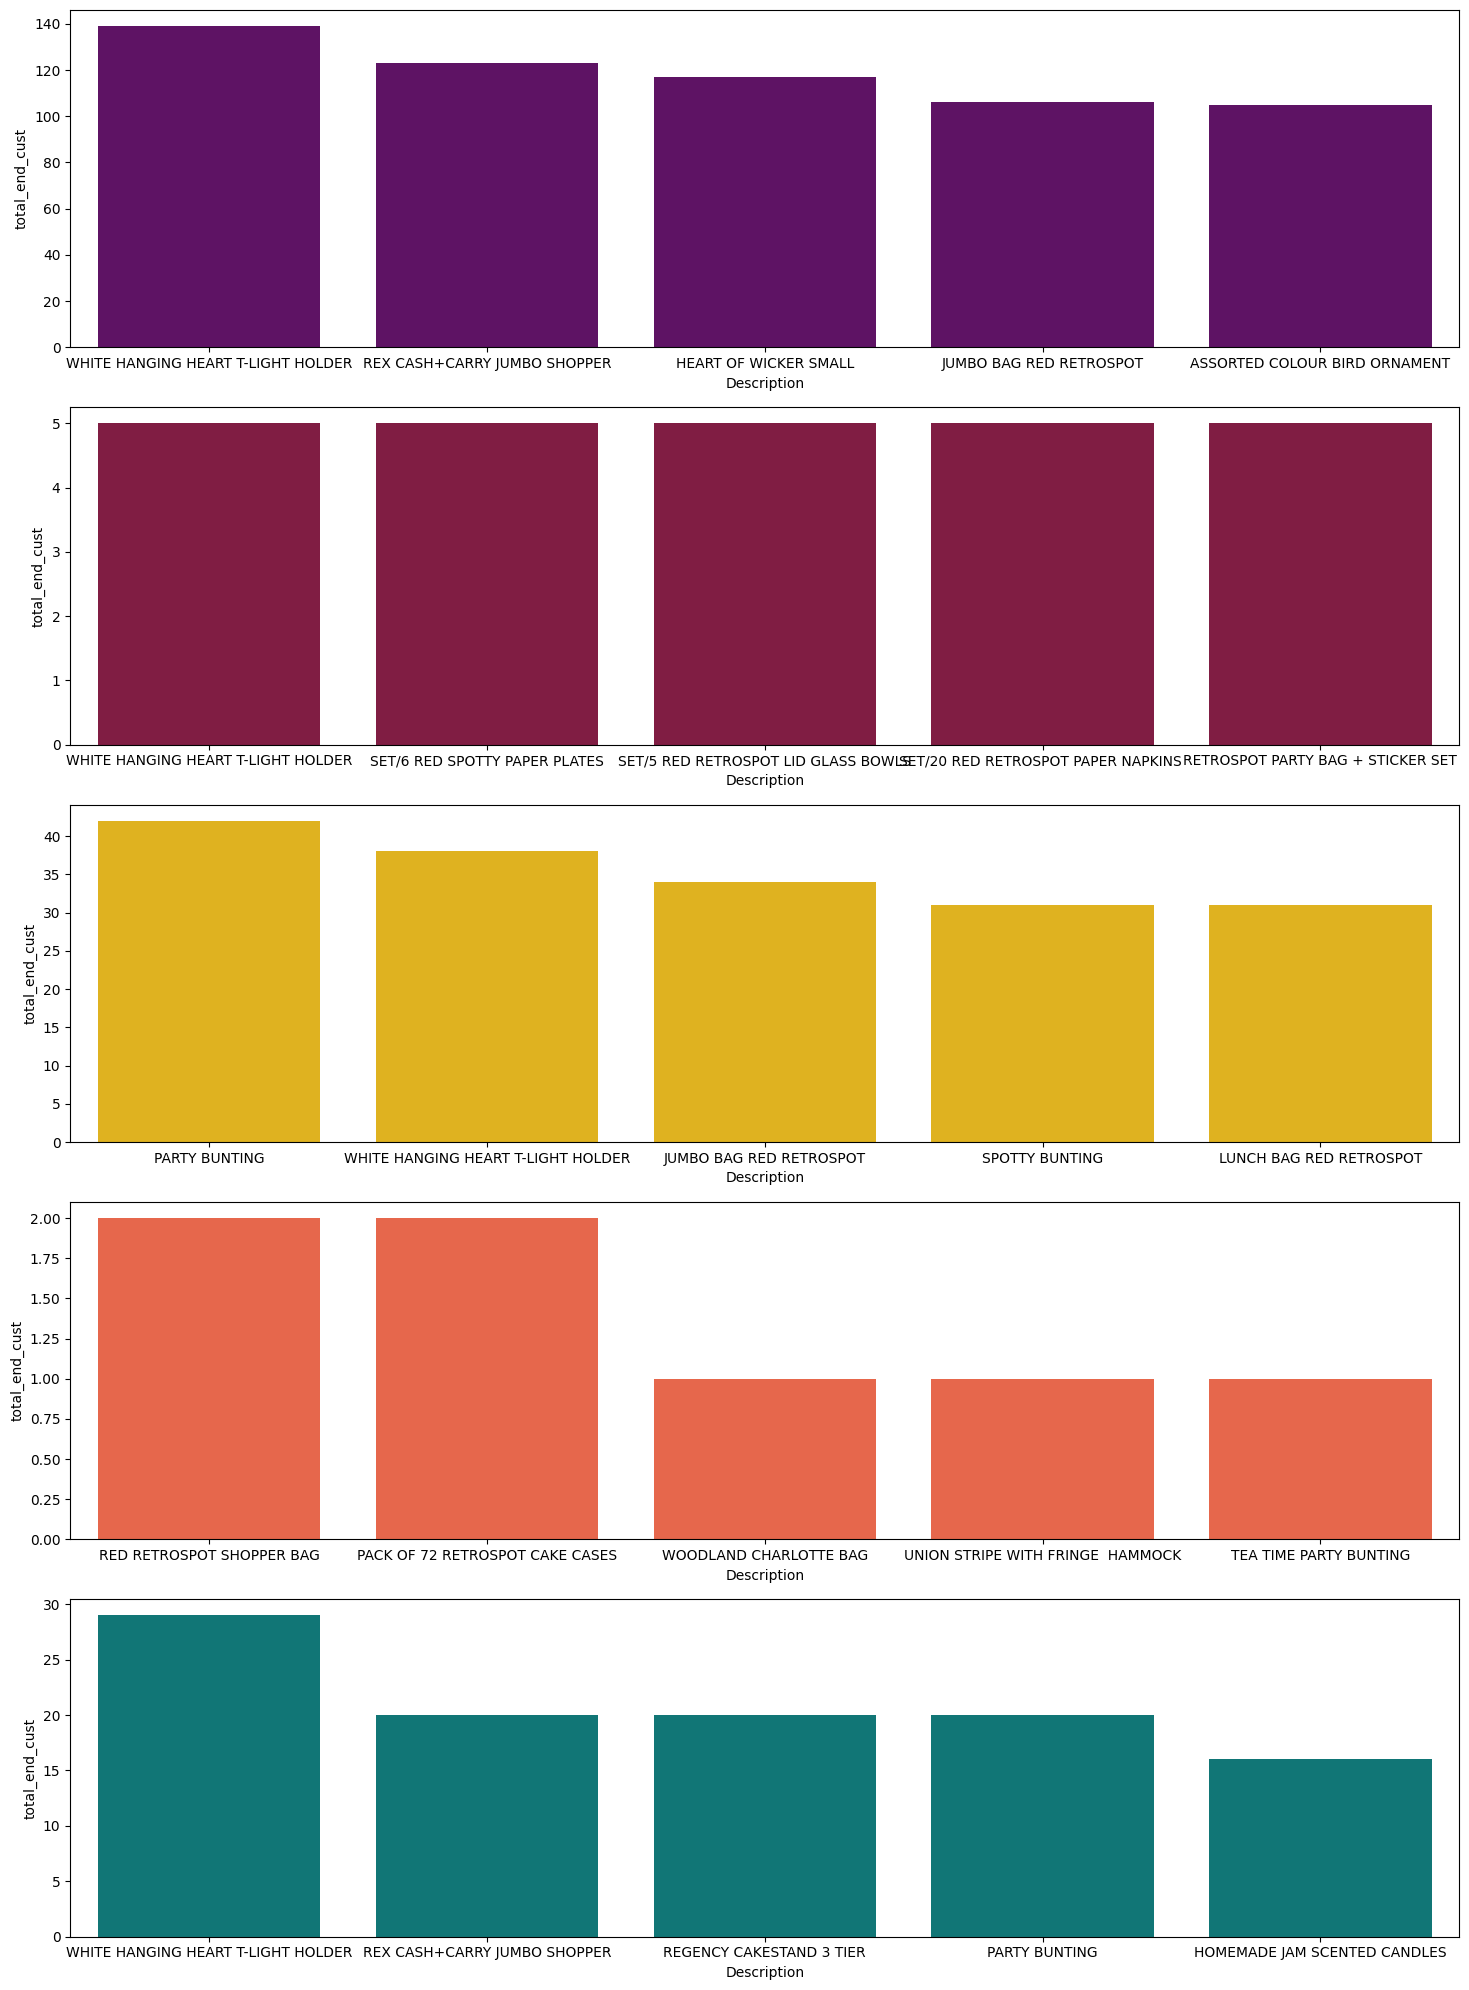

In [ ]:
fig,ax = plt.subplots(5,1,figsize=(15,20))

sns.barplot(x='Description', y='total_end_cust', data=data_we[data_we['clusters']==0][0:5], ax=ax[0], color='#6A0572')
sns.barplot(x='Description', y='total_end_cust', data=data_we[data_we['clusters']==1][0:5], ax=ax[1], color='#900C3F')
sns.barplot(x='Description', y='total_end_cust', data=data_we[data_we['clusters']==2][0:5], ax=ax[2], color='#FFC300')
sns.barplot(x='Description', y='total_end_cust', data=data_we[data_we['clusters']==3][0:5], ax=ax[3], color='#FF5733')
sns.barplot(x='Description', y='total_end_cust', data=data_we[data_we['clusters']==4][0:5], ax=ax[4], color='#008787')
# sns.barplot(x='Description', y='total_end_cust', data=data_p[data_p['clusters']==6][0:5], ax=ax[5], color='#008787')
plt.tight_layout()